# DESI PV Y1 $z$-bin TFR Calibration w/o zero-pointing

In redshift bins of width 0.005, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  Only use galaxies that pass Alex's criteria cuts:
* $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)
* $70 < V(0.4R_{26}) < 300$ km/s
* $V(0.4R_{26}) <$ minimum of (300 km/s, $10^{0.3(\mu_{CMB} - 34 + 5\log h) + 2}$)

Version: **16 September 2025**

**Note:** This version of the catalog uses only objects that John Lucey has determined to be good spirals through VI instead of the SSL morphological classifications.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [4]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys_v2.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.552104184200612e-05,122.32238811543634,11.198383235519104,N
55,SGA-2020 55,PGC12039

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [5]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [6]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

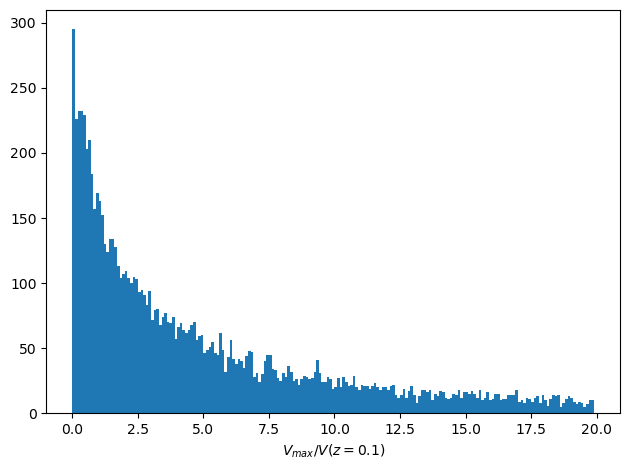

In [7]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [8]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

## Define dwarfs

We defined dwarfs to have $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)

In [9]:
# Using Alex's notation for consistency
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

Rlim_eff = np.minimum(Rlim, sgatab['MU_ZCMB'] + Mlim)
dwarf_boolean = sgatab['R_MAG_SB26'] > Rlim_eff

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We will remove all objects that John Lucey classifies as "REJECTS", "REDS", or "FACE_ON".

In [10]:
lucey_VIpath = '../VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'
reds = lucey_VIpath + 'REDS.txt'
faceon = lucey_VIpath + 'FACE_ON.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reds_tab = Table.read(reds, format='ascii.commented_header')
faceon_tab = Table.read(faceon, format='ascii.commented_header')

rejects_all = vstack([reject_tab, reds_tab, faceon_tab])
rejects_all['VI'] = 'reject'
rejects_all

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [11]:
sgatab = join(sgatab, rejects_all['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [12]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MU_ZCMB,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,mag,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,str6
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Not a dwarf galaxy
* $70~\mathrm{km/s} < V_\mathrm{rot} < 300~\mathrm{km/s}$ at $0.4R_{26}$
* $\log(V_\mathrm{rot}) <$ minimum of log(300 km/s) or $0.3(\mu(z_{CMB}) - 34 - 5\log h) + 2$

The first 1.5 items have already been applied (our VI results have already been applied, but not John's).

In [13]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

# #- Morphology cut: only ML
# is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
# for i in range(len(sgatab)):
#     if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
#         is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

# Alex's velocity cut
Vmin = 70 # km/s
Vmax = 300 # km/s
is_good_vel = (sgatab['V_0p4R26'] > Vmin) & (sgatab['V_0p4R26'] < Vmax)

#- Alex's sliding velocity maximum
logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)
is_good_vel2 = sgatab['V_0p4R26'] < np.minimum(Vmax, 10**(logVM_slope*(sgatab['MU_ZCMB'] - logVM_zero) + 2))

#- Combine selections:
is_good_sga = is_good_incl & is_good_John & ~dwarf_boolean & is_good_vel & is_good_vel2

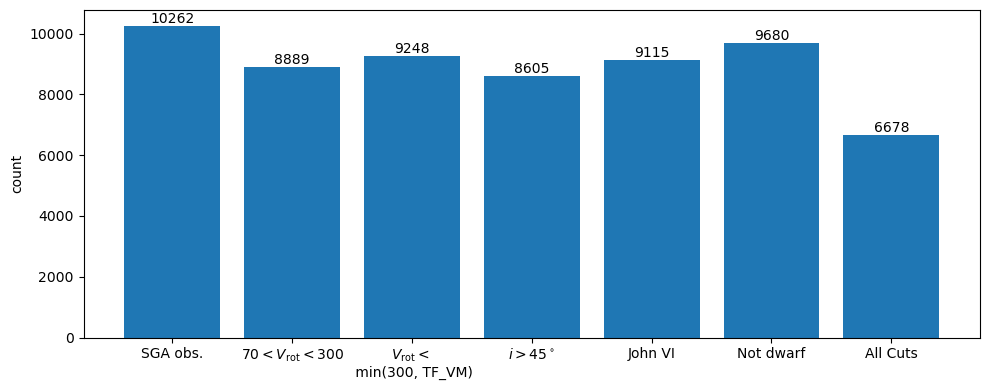

In [14]:
data = {
    'SGA obs.' : len(sgatab),
    r'$70 < V_\mathrm{rot} < 300$' : np.sum(is_good_vel),
    '$V_\mathrm{rot} <$ \n min(300, TF_VM)' : np.sum(is_good_vel2), 
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    # 'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    'Not dwarf' : np.sum(~dwarf_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(10,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [15]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [16]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [17]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [18]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [19]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [20]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [21]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [22]:
temp_infile = open('../iron_internalDust_z0p1_mcmc_09092025.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [23]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [24]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [25]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [26]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [27]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax + dz, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [28]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  509 galaxies
 1  0.030 < z <= 0.035  555 galaxies
 2  0.035 < z <= 0.040  498 galaxies
 3  0.040 < z <= 0.045  486 galaxies
 4  0.045 < z <= 0.050  486 galaxies
 5  0.050 < z <= 0.055  483 galaxies
 6  0.055 < z <= 0.060  440 galaxies
 7  0.060 < z <= 0.065  407 galaxies
 8  0.065 < z <= 0.070  413 galaxies
 9  0.070 < z <= 0.075  362 galaxies
10  0.075 < z <= 0.080  367 galaxies
11  0.080 < z <= 0.085  352 galaxies
12  0.085 < z <= 0.090  280 galaxies
13  0.090 < z <= 0.095  188 galaxies
14  0.095 < z <= 0.100  157 galaxies
15  0.100 < z <= 0.105  146 galaxies
16  z > 0.105  549 galaxies


In [29]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

146 555


# Build the Calibration Table of SGA Galaxies

In [30]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,int64,float64,float64,float64,float64
11,0.08162327483927467,38,16.712248175667224,0.10891453938544891,122.32238811543634,11.198383235519104
4,0.04508261475414366,55,16.8742754138913,0.08712849017602414,81.45040086564465,8.977326650923512
13,0.09120074612338591,117,15.93659806448035,0.11209143002585327,180.65572517100514,13.988234062982217
1,0.03484683470212291,223,16.640999631994962,0.09806655903012002,70.10200300303902,12.067030815491611
3,0.044062107713850995,581,15.205983498264104,0.14267759993906162,133.77852340476574,11.02226922144289
10,0.07586156283149581,731,16.64748009365052,0.09781199626802366,81.61279338923849,11.94046569258273
10,0.07984103741500825,1135,15.562152679376304,0.08662439109606894,218.68085076744163,6.948485705618704
4,0.04770393135250317,1158,14.794065027367324,0.10730342716464472,177.6605660298364,10.913290676982584
6,0.05517343391109497,1358,14.471689545853623,0.06505903656450926,199.7135110078093,9.873601858844548


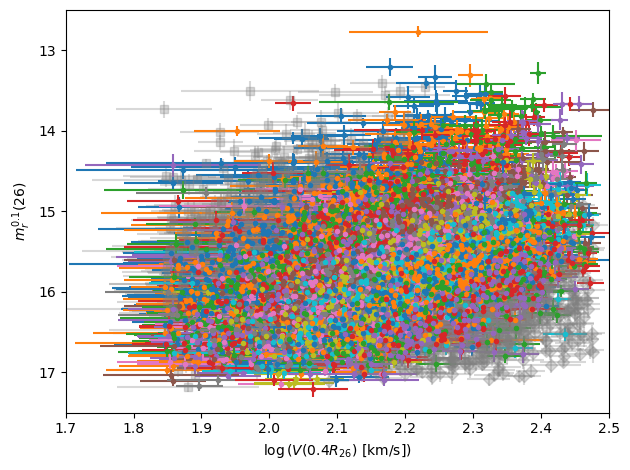

In [31]:
# fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
fig, axes = plt.subplots(1, 1, tight_layout=True)

logV0 = 0

# ax = axes[0] 
ax = axes

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.7, 2.5],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[17.5, 12.5],
       ylabel=r'$m_r^{0.1} (26)$');

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [32]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1783114225010918


## Multiline Fit using HyperFit

In [33]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -1880575.507242116
     jac: array([-8.84756451e+00,  2.02096982e+01,  1.39698375e-01,  1.52271228e+01,
        5.16883986e+00,  2.53785381e+00, -9.87201847e+00, -1.69733525e+01,
        1.86264500e+00, -5.44823661e+00, -1.76951275e+00,  1.23865892e+01,
       -5.23868905e+00,  7.12461711e+00,  2.32830624e-02, -8.87084679e+00,
       -6.46337867e+01])
 message: 'Optimization terminated successfully.'
    nfev: 40632
     nit: 157
 success: True
       x: array([-7.32041075, 14.3883925 , 14.72947887, 14.96156105, 15.16066278,
       15.40810738, 15.61651635, 15.79986932, 15.94235353, 16.11726555,
       16.26411114, 16.42604934, 16.55994542, 16.78139339, 16.93389263,
       16.89814788,  0.43482203])
Ndim: 17 15


100%|██████████| 1000/1000 [00:53<00:00, 18.71it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [75.81605646 41.52026135 60.70612905 48.29923348 46.13665926 73.28211028
 51.36308975 54.14291025 82.5084199  68.95378764 59.90780996 74.44086656
 62.75902336 75.32063516 76.13054189 82.20072491 85.96801748] / 4298.40087393229


100%|██████████| 1000/1000 [00:53<00:00, 18.75it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.03895923  47.39542271  50.40391394  49.63621885  56.74162451
  64.31147004  72.50351511  82.92002555  65.78375232  74.31359488
  68.57116136  74.8848768   86.76788292  89.30055968 101.97020975
  83.96870907 106.22644544] / 5311.322271852461


100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [111.9441227   37.66691531  44.76587989  47.1524552   57.34758745
  64.78055149  75.83682073  82.24425641  76.39932694  73.95967501
  83.10575629  83.7754241   99.95861589  97.44122862  95.52473038
  99.25803274 110.78713326] / 5597.206135170474


100%|██████████| 1000/1000 [00:52<00:00, 19.13it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [105.96818625  46.67406482  57.24023111  54.45527195  59.23244633
  67.9885838   67.02835988  78.59999787  91.83347575  92.88861032
  91.91152467  87.96357554  93.74257933 119.29945743 108.09157977
 110.92665124 122.61276664] / 6130.638331877901


100%|██████████| 1000/1000 [00:54<00:00, 18.21it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [116.03690335  46.06066908  55.60261059  60.61231018  53.51414561
  77.89977741  71.00137004  80.1001566   95.92392546  93.17288001
  99.29079291  98.96684465 107.40174695 136.97775697 108.58035552
 130.24637581 121.31738034] / 6848.887848431539


100%|██████████| 1000/1000 [00:57<00:00, 17.28it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [131.58787501  53.40215516  56.28664902  63.53078777  62.09971838
  79.12160301  76.69507049  85.84454552 100.32220187 102.11263521
 104.28115089 105.457532   110.13185562 135.76667633 112.4186967
 127.18076599 116.09539863] / 6788.333816601862


100%|██████████| 1000/1000 [00:57<00:00, 17.24it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [135.87315856  50.8951515   55.47620034  64.48085196  62.34754047
  76.49204364  80.1377935   85.7416006  105.68205688 104.09104141
 103.3751825  103.75630944 119.48343891 143.34384219 137.5437077
 134.46001113 117.3372677 ] / 7167.19210947836


100%|██████████| 1000/1000 [00:54<00:00, 18.50it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [135.15423821  50.51270225  55.47366277  68.75002229  64.98352389
  74.53982573  84.96860745  83.26153178 105.8388727  100.35177584
 110.36026837 105.02255016 125.97538782 141.09663118 147.76274822
 134.14717587 131.78530109] / 7388.137411082602


100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [137.79984423  48.76983175  54.14474774  69.04987407  65.70335689
  77.52590048  87.70115393  84.77345889 103.96424055 102.73434081
 115.15045949 118.98170204 123.78107643 143.39334777 153.32826941
 155.29257074 138.341353  ] / 7764.628536853464


100%|██████████| 1000/1000 [00:57<00:00, 17.32it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.07337951  52.01995371  55.4086889   70.85347629  66.36629259
  68.69286113  80.28333605  85.82040044 107.30372798 103.15823463
 117.41936716 119.91747484 118.73308011 136.75031896 147.16163566
 149.77826833 145.13138268] / 7553.66897569975


100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.82303276  52.24928114  56.25017787  66.70129398  66.92905565
  70.00527157  81.25159933  85.72126371 113.06005157 103.77795059
 113.39701332 125.64612374 122.79712538 138.65793496 155.65385246
 155.98901927 143.39839499] / 7841.151637769123


100%|██████████| 1000/1000 [00:56<00:00, 17.80it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.78724811  50.30095046  57.5958107   70.42470089  69.73785255
  69.7467957   83.87689108  85.55477459 105.20888666 106.23983097
 112.97379401 129.55223893 123.77924236 143.78323549 147.93211576
 156.24915735 143.89592921] / 7889.362405689071


100%|██████████| 1000/1000 [00:54<00:00, 18.44it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [154.64353356  48.62683379  57.27560248  67.28303838  68.53961371
  72.52725559  81.90627079  84.74662136 105.51555227 106.34932893
 113.13418287 126.41421033 127.05544105 149.01635112 143.79939759
 163.73956732 151.75410153] / 8186.97836583695


100%|██████████| 1000/1000 [00:53<00:00, 18.78it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [155.7036788   49.52257926  57.7430439   68.56856244  71.54787756
  71.2616548   81.90122469  88.19710454 105.21725935 106.40397075
 112.91573413 130.97488572 136.94961087 155.94499488 143.78538008
 167.50652828 159.24891117] / 8375.326414033598


100%|██████████| 1000/1000 [00:52<00:00, 18.91it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.45558972  48.42024175  57.84087595  64.21914768  70.47893664
  74.73792719  78.98570742  90.47626397 106.84922146 105.60791366
 113.95618964 130.55666731 140.93746881 154.79064428 148.14803664
 177.49791262 161.35422152] / 8874.895631041321


100%|██████████| 1000/1000 [00:53<00:00, 18.81it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [158.43387167  51.23293205  58.19233983  63.74762151  71.13747876
  73.09155102  80.32904231  95.05936857 108.5563872  111.04328145
 115.70685471 135.63913437 145.32749783 151.57508501 146.80260311
 180.39660259 158.85224868] / 9019.830129475278


100%|██████████| 1000/1000 [00:52<00:00, 19.01it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [169.2190824   50.76222315  59.0410318   61.27641862  70.24123674
  71.94408051  81.76136486  92.83270662 104.58730256 110.76401087
 116.77110173 133.48360599 147.30758591 161.7626308  147.35517716
 178.6718771  166.19696122] / 8933.593855047942


100%|██████████| 1000/1000 [00:53<00:00, 18.78it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [169.37250795  50.46478278  58.46277524  61.17367907  72.67218568
  70.83318076  82.22113782  93.77850636 105.96678337 111.99235389
 117.28592314 137.86235462 146.66052421 166.39886101 150.93245517
 183.38390047 151.62576559] / 9169.195023269871


100%|██████████| 1000/1000 [00:52<00:00, 19.00it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [174.1964414   48.71773869  57.96937685  60.50816724  71.80876748
  71.53206226  80.91334118  90.72489827 103.95996268 111.42336266
 117.19095507 137.48279054 149.81673142 163.78841927 151.84358085
 191.27439562 155.84648233] / 9563.71978080402


In [34]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/cov_ab_iron_jointTFR_v14mod_JohnVI.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

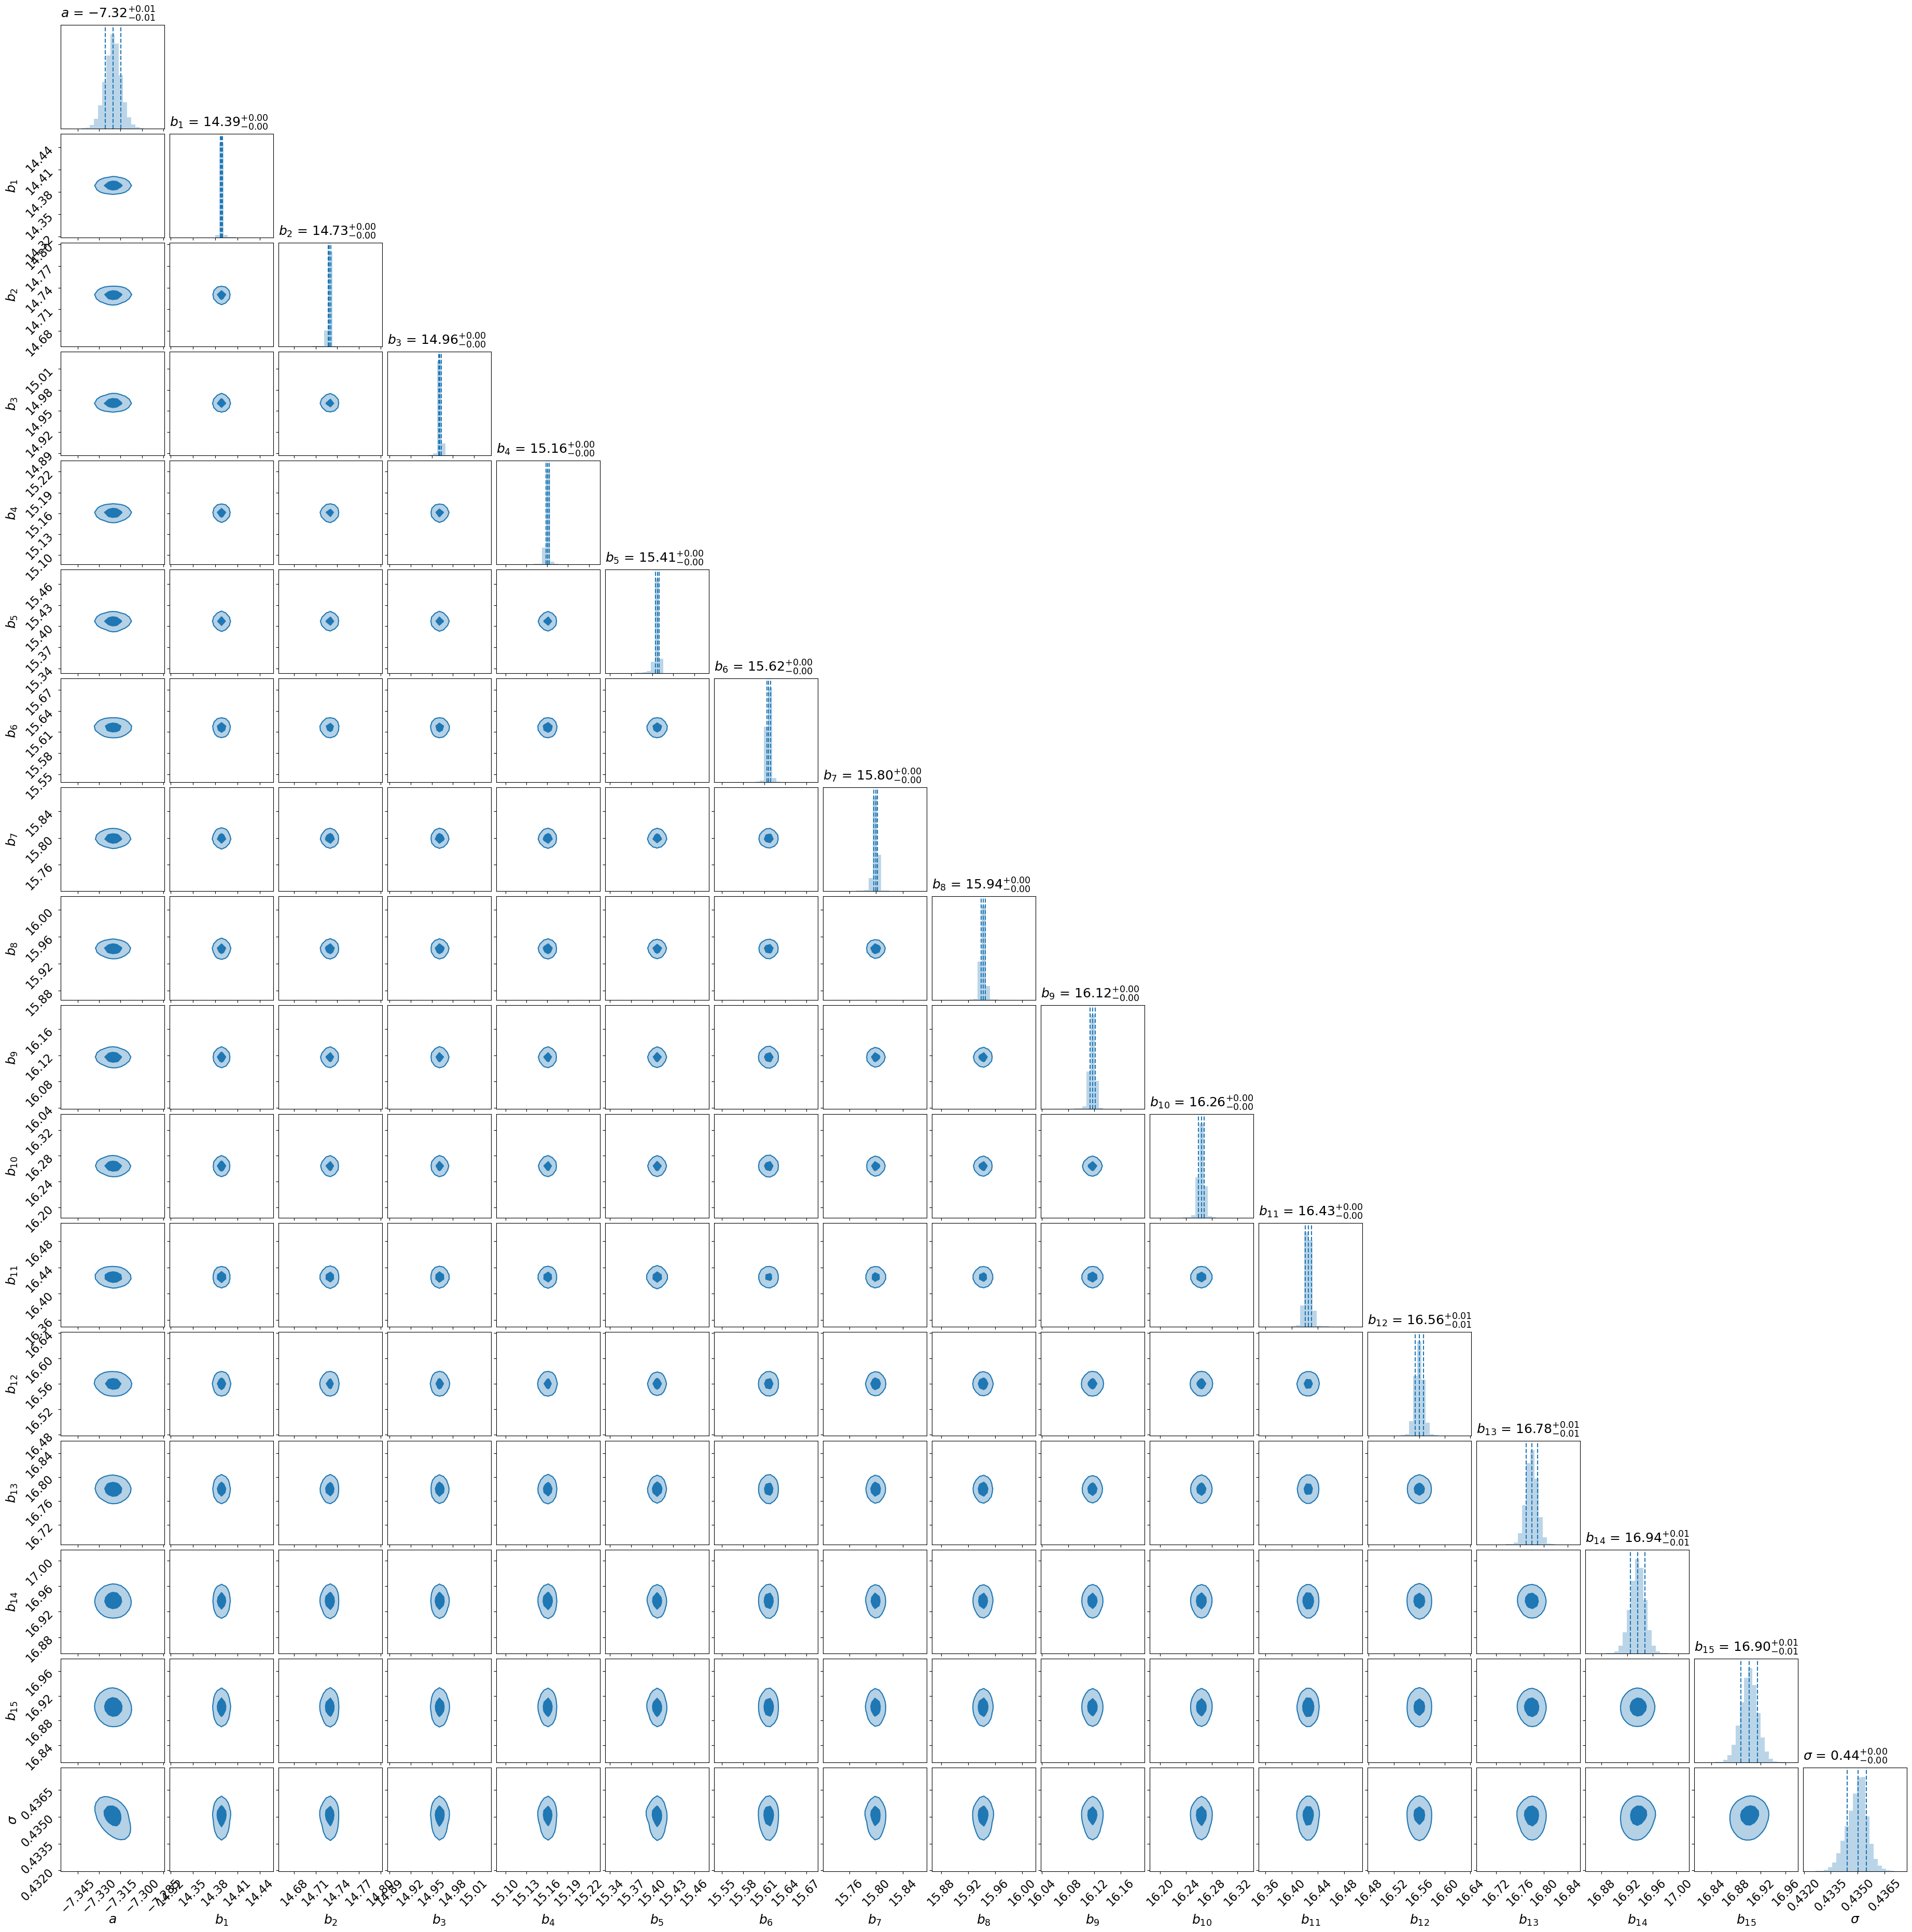

In [35]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$']

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [36]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

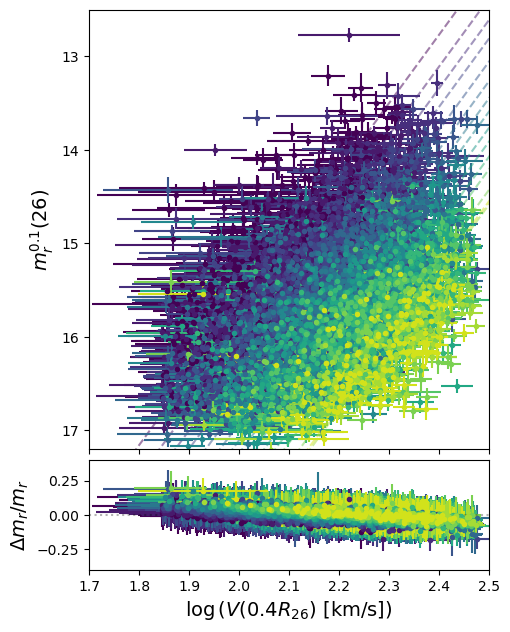

In [37]:
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b_   = b_mcmc[:,1]

#- Plot redshift bins
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],
                     y=mag[k],
                     xerr=logV_err[k],
                     yerr=mag_err[k],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.7, 2.5],
       ylim=[17.2, 12.5])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot residuals: z-bins
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]
    m_obs = mag[k]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],
                     yerr=mag_err[k],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [38]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.93 +/- 0.002


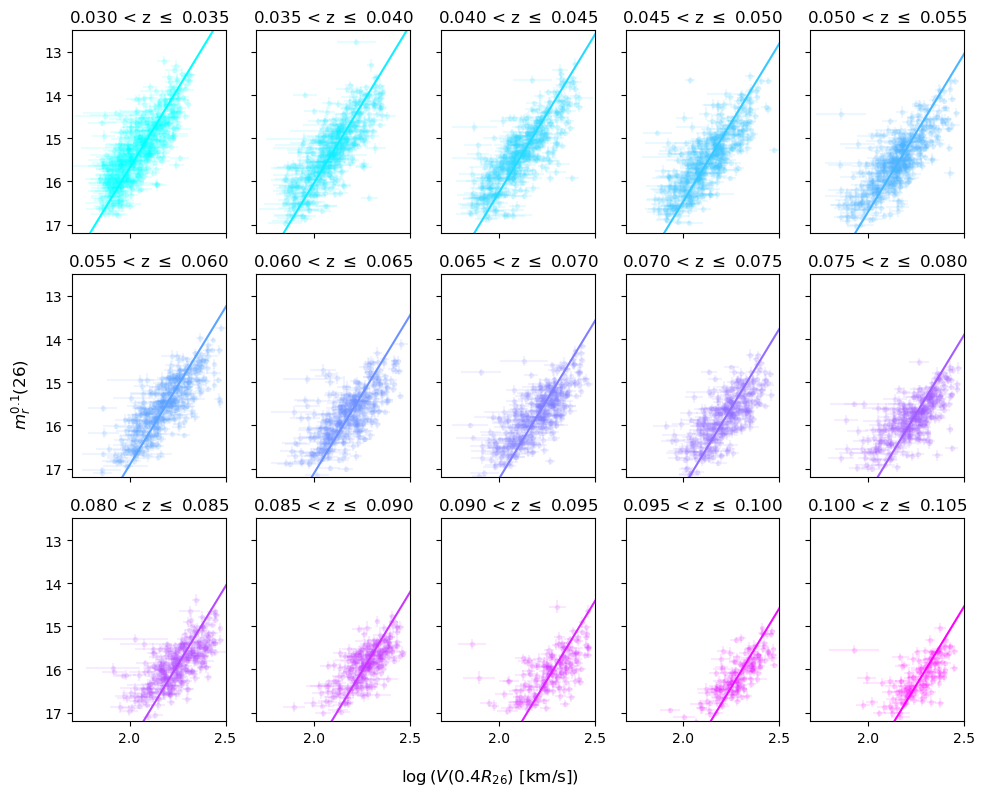

In [39]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],
                               mag[i],
                               xerr=logV_err[i],
                               yerr=mag_err[i],
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.7, 2.5], ylim=[17.2, 12.5], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')